<a href="https://colab.research.google.com/github/ngoclinhle/AI_IC_2020/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML  

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw


Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw


Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw


Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw
Processing...
Done!




/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


torch.Size([16, 1, 28, 28])
torch.Size([3, 62, 242])


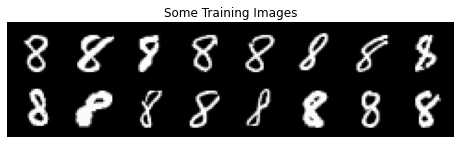

In [ ]:
# Hyper-parameters
batch_size = 64
workers = 4
num_epochs = 100
lr = 0.0002
beta1 = 0.5
image_size = 28
latent_size = 100
hidden1_size = image_size*image_size*8
output_size = image_size*image_size

transform = transforms.Compose([
  transforms.Resize(image_size),
  transforms.CenterCrop(image_size),
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5)
])

#set up dataset
dataset = torchvision.datasets.MNIST(root='../../data/',
                                    train=True, 
                                    transform=transform,
                                    download=True)

#select only images of number 8
target = 8
idx = (dataset.targets == target)
dataset.data = dataset.data[idx]
dataset.targets = torch.Tensor(np.ones(len(idx))) #all sample in train is real

loader = torch.utils.data.DataLoader(dataset=dataset,
                                    batch_size=batch_size, 
                                    shuffle=True,
                                    num_workers=workers)

#display some training image
batch = next(iter(loader))
plt.figure(figsize=(8,4))
plt.axis("off")
plt.title("Some Training Images")
images = vutils.make_grid(batch[0].to(device)[:16], padding=2, normalize=True).cpu()
print(batch[0].to(device)[:16].shape)
print(images.shape)
plt.imshow(np.transpose(images ,(1,2,0)))
plt.show()


In [ ]:
def weight_init(m):
  classname = m.__class__.__name__
  if classname.find('Linear') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.2)
    if (m.bias != None):
      nn.init.constant_(m.bias.data, 0)
    else:
      return
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)
  elif classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)

hidden1_size = 28*28
hidden2_size = 28*28
hidden3_size = 28*28
hidden4_size = 28*28
hidden5_size = 28*28

class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.fc0 = nn.Linear(latent_size, 128*7*7)
    self.activation0 = nn.LeakyReLU(0.2, True)
    self.cnv1 = nn.ConvTranspose2d(128, 128, (4,4), (2,2))
    self.bn1 = nn.BatchNorm2d(128)
    self.activation1 = nn.LeakyReLU(0.2, True)
    self.cnv2 = nn.ConvTranspose2d(128, 128, (4,4), (2,2))
    self.bn2 = nn.BatchNorm2d(128)
    self.activation2 = nn.LeakyReLU(0.2)
    self.cnv3 = nn.Conv2d(128, 1, (7,7))
    self.bn3 = nn.BatchNorm2d(1)
    self.activation3 = nn.Tanh()
    # self.main = nn.Sequential(
    #   nn.Linear(latent_size, hidden1_size, bias=True)
      # nn.ReLU(True),
      # nn.Linear(hidden1_size, hidden2_size, bias=True),
      # # nn.BatchNorm1d(hidden2_size),
      # nn.ReLU(True),
      # nn.Linear(hidden2_size, hidden3_size, bias=True),
      # # nn.BatchNorm1d(hidden3_size),
      # nn.ReLU(True),
      # nn.Linear(hidden3_size, hidden4_size, bias=True),
      # # nn.BatchNorm1d(hidden3_size),
      # nn.ReLU(True),
      # nn.Linear(hidden4_size, hidden5_size, bias=True),
      # # nn.BatchNorm1d(hidden3_size),
      # nn.ReLU(True),
      # nn.Linear(hidden5_size, output_size, bias=True),
      # nn.Tanh()
    # )

  def forward(self, input):
    B = input.shape[0]
    # X = self.main(input)
    # return X.view(B, 1, image_size, image_size)
    x = self.activation0(self.fc0(input)).view(B,128,7,7)
    x = self.activation1(self.bn1(self.cnv1(x)))
    x = self.activation2(self.bn2(self.cnv2(x)))
    x = self.activation3(self.bn3(self.cnv3(x)))

    return x

netG = Generator().to(device)
netG.apply(weight_init)

# Discriminator Code
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(
      nn.Linear(output_size, hidden1_size, bias=True),
      nn.BatchNorm1d(hidden1_size),
      nn.ReLU(True),
      nn.Linear(hidden1_size, 1, bias=True),
      nn.Sigmoid()
    )

  def forward(self, input):
    b_size = input.size(0)
    return self.main(input.view(b_size, -1))

netD = Discriminator().to(device)
netD.apply(weight_init)

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=784, bias=True)
    (1): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=784, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(16, latent_size, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

In [ ]:
# Training Loop

print("Starting Training Loop...")
num_d = 1
num_g = 4

# For each epoch
errD_last = 1
errG_last = 1
last_epoch = False
for epoch in range(num_epochs):
  # For each batch in the dataloader
  if (not last_epoch):
    for i, data in enumerate(loader, 0):
      ############################
      # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
      ###########################
      ## Train with all-real batch
      if errD_last > 0.001:
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.shape[0]
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_size, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        errD_last = errD.item()

      ############################
      # (2) Update G network: maximize log(D(G(z)))
      ###########################
      if errG_last > 0.01:
        netG.zero_grad()
        noise = torch.randn(b_size, latent_size, device=device)
        fake = netG(noise)
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        errG_last = errG.item()

      # Output training stats
      if i % 50 == 0:
        print('[epoch %d/%d][batch %d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
              % (epoch, num_epochs, i, len(loader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

      # Save Losses for plotting later
      G_losses.append(errG.item())
      D_losses.append(errD.item())

      # Check how the generator is doing by saving G's output on fixed_noise
      if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(loader)-1)):
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

      iters += 1

      last_epoch = errD_last < 0.001 and errG_last < 0.01

Starting Training Loop...
[epoch 0/1000][batch 0/92]	Loss_D: 3.6613	Loss_G: 0.4306	D(x): 0.7965	D(G(z)): 0.7995 / 0.7639
[epoch 0/1000][batch 50/92]	Loss_D: 2.2030	Loss_G: 1.2307	D(x): 0.5522	D(G(z)): 0.5305 / 0.4962
[epoch 1/1000][batch 0/92]	Loss_D: 1.8941	Loss_G: 1.0152	D(x): 0.5598	D(G(z)): 0.4752 / 0.5116
[epoch 1/1000][batch 50/92]	Loss_D: 1.8787	Loss_G: 1.0389	D(x): 0.5200	D(G(z)): 0.4688 / 0.4762
[epoch 2/1000][batch 0/92]	Loss_D: 1.7659	Loss_G: 1.0749	D(x): 0.5330	D(G(z)): 0.4755 / 0.4860
[epoch 2/1000][batch 50/92]	Loss_D: 1.7025	Loss_G: 1.0534	D(x): 0.5216	D(G(z)): 0.4661 / 0.4599
[epoch 3/1000][batch 0/92]	Loss_D: 1.7861	Loss_G: 0.9648	D(x): 0.5314	D(G(z)): 0.5032 / 0.4882
[epoch 3/1000][batch 50/92]	Loss_D: 1.5146	Loss_G: 1.0245	D(x): 0.5094	D(G(z)): 0.4342 / 0.4739
[epoch 4/1000][batch 0/92]	Loss_D: 1.4389	Loss_G: 0.9719	D(x): 0.5627	D(G(z)): 0.4573 / 0.4554
[epoch 4/1000][batch 50/92]	Loss_D: 1.3782	Loss_G: 1.1235	D(x): 0.5916	D(G(z)): 0.4636 / 0.4321
[epoch 5/1000][batc

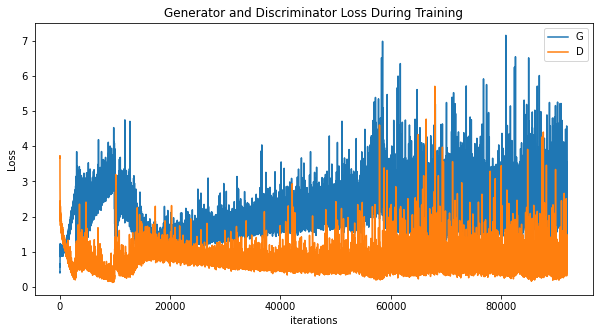

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

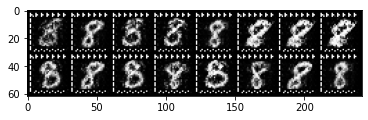

In [22]:
plt.imshow(np.transpose(img_list[-1], (1,2,0)))

In [ ]:
torch.save(netG.state_dict(), )